#  Project Overview
This notebook implements and compares two RL algorithms (DQN and PPO) on a custom therapy grid environment.

In [1]:
env_code = """
import gymnasium as gym
from gymnasium import spaces
import numpy as np

class TherapyEnv(gym.Env):
    def __init__(self):
        super(TherapyEnv, self).__init__()
        self.grid_size = 5
        self.action_space = spaces.Discrete(4)
        self.observation_space = spaces.Box(low=0, high=self.grid_size - 1, shape=(2,), dtype=np.int32)
        self.goal_pos = np.array([4, 3])
        self.state = None

    def reset(self, seed=None, options=None):
        super().reset(seed=seed)
        self.state = np.array([0, 0])
        return self.state, {}

    def step(self, action):
        x, y = self.state
        if action == 0: x = max(x - 1, 0)
        elif action == 1: x = min(x + 1, self.grid_size - 1)
        elif action == 2: y = max(y - 1, 0)
        elif action == 3: y = min(y + 1, self.grid_size - 1)
        self.state = np.array([x, y])
        reward = -1
        done = np.array_equal(self.state, self.goal_pos)
        if done:
            reward = 10
        return self.state, reward, done, False, {}

    def render(self):
        print(f"Agent at {self.state}")
"""

# Save it to a .py file
with open("custom_env.py", "w") as f:
    f.write(env_code)

print("✅ custom_env.py has been created!")



✅ custom_env.py has been created!


The action space is discrete, with 4 fixed movement actions:

## Custom Environment (TherapyEnv)
This section defines the Gym-compatible environment simulating a therapy decision process.

In [2]:
# Define your PyOpenGL rendering code as a string
rendering_code = """
from OpenGL.GL import *
from OpenGL.GLUT import *
from OpenGL.GLU import *
import random

# ====== CONFIG ======
GRID_SIZE = 5
CELL_SIZE = 0.3
WINDOW_WIDTH = 600
WINDOW_HEIGHT = 600

agent_pos = (random.randint(0, GRID_SIZE - 1), random.randint(0, GRID_SIZE - 1))

therapy_labels = {
    (0, 0): ("Journaling", (0.5, 0.8, 1.0)),   # Light Blue
    (1, 2): ("Breathing", (0.7, 0.9, 1.0)),    # Sky Blue
    (3, 1): ("Chatbot", (0.8, 0.6, 1.0)),      # Lavender
    (2, 4): ("CBT", (0.5, 1.0, 0.9)),          # Teal
    (4, 3): ("Crisis", (1.0,
} 0.4, 0.4))        # Red

def draw_grid():
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            if (x, y) in therapy_labels:
                _, color = therapy_labels[(x, y)]
                glColor3f(*color)
            else:
                glColor3f(0.9, 0.9, 0.9)

            glBegin(GL_QUADS)
            glVertex2f(x * CELL_SIZE, y * CELL_SIZE)
            glVertex2f((x + 1) * CELL_SIZE, y * CELL_SIZE)
            glVertex2f((x + 1) * CELL_SIZE, (y + 1) * CELL_SIZE)
            glVertex2f(x * CELL_SIZE, (y + 1) * CELL_SIZE)
            glEnd()

            glColor3f(0.2, 0.2, 0.2)
            glBegin(GL_LINE_LOOP)
            glVertex2f(x * CELL_SIZE, y * CELL_SIZE)
            glVertex2f((x + 1) * CELL_SIZE, y * CELL_SIZE)
            glVertex2f((x + 1) * CELL_SIZE, (y + 1) * CELL_SIZE)
            glVertex2f(x * CELL_SIZE, (y + 1) * CELL_SIZE)
            glEnd()

def draw_labels():
    glColor3f(0, 0, 0)
    for (x, y), (label, _) in therapy_labels.items():
        glRasterPos2f(x * CELL_SIZE + 0.05, y * CELL_SIZE + 0.12)
        for ch in label:
            glutBitmapCharacter(GLUT_BITMAP_HELVETICA_12, ord(ch))

def draw_agent():
    x, y = agent_pos
    glColor3f(0.0, 1.0, 0.0)
    margin = 0.05
    glBegin(GL_QUADS)
    glVertex2f(x * CELL_SIZE + margin, y * CELL_SIZE + margin)
    glVertex2f((x + 1) * CELL_SIZE - margin, y * CELL_SIZE + margin)
    glVertex2f((x + 1) * CELL_SIZE - margin, (y + 1) * CELL_SIZE - margin)
    glVertex2f(x * CELL_SIZE + margin, (y + 1) * CELL_SIZE - margin)
    glEnd()

def display():
    glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
    glLoadIdentity()
    draw_grid()
    draw_labels()
    draw_agent()
    glutSwapBuffers()

def reshape(w, h):
    glViewport(0, 0, w, h)
    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()
    gluOrtho2D(0.0, GRID_SIZE * CELL_SIZE, 0.0, GRID_SIZE * CELL_SIZE)
    glMatrixMode(GL_MODELVIEW)

def main():
    glutInit()
    glutInitDisplayMode(GLUT_RGBA | GLUT_DOUBLE | GLUT_DEPTH)
    glutInitWindowSize(WINDOW_WIDTH, WINDOW_HEIGHT)
    glutInitWindowPosition(100, 100)
    glutCreateWindow(b"Therapy Environment - PyOpenGL")
    glClearColor(1.0, 1.0, 1.0, 1.0)
    glutDisplayFunc(display)
    glutReshapeFunc(reshape)
    glutMainLoop()

if __name__ == "__main__":
    main()
"""

# Save the code to rendering.py
with open("rendering.py", "w") as f:
    f.write(rendering_code)

# Download the file to your local computer
from google.colab import files
files.download("rendering.py")



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

##  DQN Training
Here we train a Deep Q-Network (Value-Based RL) using Stable-Baselines3.

In [3]:
!pip install stable-baselines3[extra] gymnasium


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 55.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 41.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 10.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 62.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.5/184.5 kB 15.4 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstall

In [4]:
!pip install stable-baselines3[extra] gymnasium


.

In [5]:
from custom_env import TherapyEnv
from stable_baselines3 import DQN

env = TherapyEnv()
dqn_model = DQN(
    "MlpPolicy",
    env,
    learning_rate=0.001,
    gamma=0.99,
    buffer_size=10000,
    batch_size=64,
    exploration_fraction=0.1,
    exploration_final_eps=0.02,
    verbose=1
)
dqn_model.learn(total_timesteps=10000)
dqn_model.save("dqn_model")
print("✅ DQN training done!")


Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 51       |
|    ep_rew_mean      | -40      |
|    exploration_rate | 0.8      |
| time/               |          |
|    episodes         | 4        |
|    fps              | 193      |
|    time_elapsed     | 1        |
|    total_timesteps  | 204      |
| train/              |          |
|    learning_rate    | 0.001    |
|    loss             | 0.402    |
|    n_updates        | 25       |
----------------------------------
----------------------------------
| rollout/            |          |
|    ep_len_mean      | 38.8     |
|    ep_rew_mean      | -27.8    |
|    exploration_rate | 0.696    |
| time/               |          |
|    episodes         | 8        |
|    fps              | 267      |
|    time_elapsed     | 1        |
|    total_timesteps  | 310      |
| train/              |       

PPO TRAINING

In [6]:
from stable_baselines3 import PPO

env = TherapyEnv()
ppo_model = PPO(
    "MlpPolicy",
    env,
    learning_rate=0.0003,
    gamma=0.95,
    n_steps=512,
    batch_size=64,
    verbose=1
)
ppo_model.learn(total_timesteps=10000)
ppo_model.save("ppo_model")
print("✅ PPO training done!")



Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.


/usr/local/lib/python3.11/dist-packages/stable_baselines3/common/on_policy_algorithm.py:150: UserWarning: You are trying to run PPO on the GPU, but it is primarily intended to run on the CPU when not using a CNN policy (you are using ActorCriticPolicy which should be a MlpPolicy). See https://github.com/DLR-RM/stable-baselines3/issues/1245 for more info. You can pass `device='cpu'` or `export CUDA_VISIBLE_DEVICES=` to force using the CPU.Note: The model will train, but the GPU utilization will be poor and the training might take longer than on CPU.
  warnings.warn(


---------------------------------
| rollout/           |          |
|    ep_len_mean     | 92.8     |
|    ep_rew_mean     | -81.8    |
| time/              |          |
|    fps             | 325      |
|    iterations      | 1        |
|    time_elapsed    | 1        |
|    total_timesteps | 512      |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 61.8        |
|    ep_rew_mean          | -50.8       |
| time/                   |             |
|    fps                  | 365         |
|    iterations           | 2           |
|    time_elapsed         | 2           |
|    total_timesteps      | 1024        |
| train/                  |             |
|    approx_kl            | 0.011995215 |
|    clip_fraction        | 0.14        |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.38       |
|    explained_variance   | 0.024       |
|    learning_rate        | 0.

Evaluation Rewards

In [7]:
from stable_baselines3 import DQN, PPO

env = TherapyEnv()
dqn_model = DQN.load("dqn_model")
ppo_model = PPO.load("ppo_model")

def run_model(model, name):
    rewards = []
    for ep in range(10):
        obs = env.reset()[0]
        done = False
        ep_reward = 0
        steps = 0
        while not done and steps < 50:
            action, _ = model.predict(obs, deterministic=True)
            obs, reward, done, _, _ = env.step(action)
            ep_reward += reward
            steps += 1
        rewards.append(ep_reward)
    print(f"{name} Average Reward: {sum(rewards)/len(rewards)}")
    return rewards

dqn_rewards = run_model(dqn_model, "DQN")
ppo_rewards = run_model(ppo_model, "PPO")


DQN Average Reward: -50.0
PPO Average Reward: 4.0


PLOT OPTIONAL

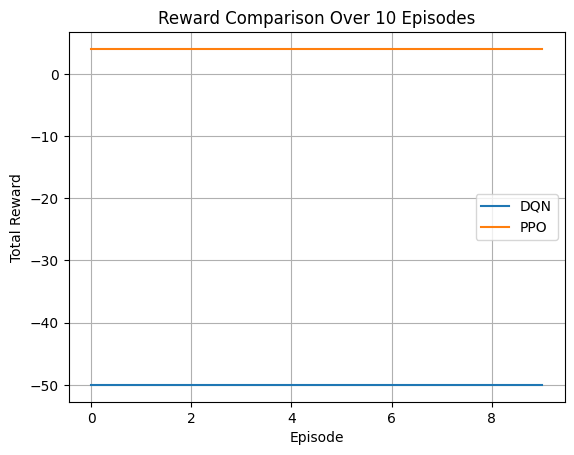

In [8]:
import matplotlib.pyplot as plt

plt.plot(dqn_rewards, label="DQN")
plt.plot(ppo_rewards, label="PPO")
plt.title("Reward Comparison Over 10 Episodes")
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.legend()
plt.grid(True)
plt.show()


AGENT WORKING

In [9]:
# Rewriting the file after kernel reset
rendering_active_code = """
from OpenGL.GL import *
from OpenGL.GLUT import *
from OpenGL.GLU import *
import time

# ====== CONFIG ======
GRID_SIZE = 5
CELL_SIZE = 0.3
WINDOW_WIDTH = 600
WINDOW_HEIGHT = 600

# Goal position
goal_pos = (4, 3)

# Define path (you can replace this with a real policy path)
agent_path = [(0, 0), (1, 0), (2, 0), (2, 1), (2, 2), (3, 2), (4, 2), (4, 3)]

# Therapy labels
therapy_labels = {
    (0, 0): ("Journaling", (0.5, 0.8, 1.0)),
    (1, 2): ("Breathing", (0.7, 0.9, 1.0)),
    (3, 1): ("Chatbot", (0.8, 0.6, 1.0)),
    (2, 4): ("CBT", (0.5, 1.0, 0.9)),
    (4, 3): ("Crisis", (1.0, 0.4, 0.4))
}

# Agent simulation state
current_step = 0

def draw_grid():
    for x in range(GRID_SIZE):
        for y in range(GRID_SIZE):
            if (x, y) in therapy_labels:
                _, color = therapy_labels[(x, y)]
                glColor3f(*color)
            else:
                glColor3f(0.9, 0.9, 0.9)

            glBegin(GL_QUADS)
            glVertex2f(x * CELL_SIZE, y * CELL_SIZE)
            glVertex2f((x + 1) * CELL_SIZE, y * CELL_SIZE)
            glVertex2f((x + 1) * CELL_SIZE, (y + 1) * CELL_SIZE)
            glVertex2f(x * CELL_SIZE, (y + 1) * CELL_SIZE)
            glEnd()

            glColor3f(0.2, 0.2, 0.2)
            glBegin(GL_LINE_LOOP)
            glVertex2f(x * CELL_SIZE, y * CELL_SIZE)
            glVertex2f((x + 1) * CELL_SIZE, y * CELL_SIZE)
            glVertex2f((x + 1) * CELL_SIZE, (y + 1) * CELL_SIZE)
            glVertex2f(x * CELL_SIZE, (y + 1) * CELL_SIZE)
            glEnd()

def draw_labels():
    glColor3f(0, 0, 0)
    for (x, y), (label, _) in therapy_labels.items():
        glRasterPos2f(x * CELL_SIZE + 0.05, y * CELL_SIZE + 0.12)
        for ch in label:
            glutBitmapCharacter(GLUT_BITMAP_HELVETICA_12, ord(ch))

def draw_agent():
    global current_step
    if current_step >= len(agent_path):
        return

    x, y = agent_path[current_step]
    glColor3f(0.0, 1.0, 0.0)
    margin = 0.05
    glBegin(GL_QUADS)
    glVertex2f(x * CELL_SIZE + margin, y * CELL_SIZE + margin)
    glVertex2f((x + 1) * CELL_SIZE - margin, y * CELL_SIZE + margin)
    glVertex2f((x + 1) * CELL_SIZE - margin, (y + 1) * CELL_SIZE - margin)
    glVertex2f(x * CELL_SIZE + margin, (y + 1) * CELL_SIZE - margin)
    glEnd()

def display():
    glClear(GL_COLOR_BUFFER_BIT | GL_DEPTH_BUFFER_BIT)
    glLoadIdentity()
    draw_grid()
    draw_labels()
    draw_agent()
    glutSwapBuffers()

def update(value):
    global current_step
    current_step += 1
    if current_step < len(agent_path):
        glutPostRedisplay()
        glutTimerFunc(700, update, 0)
    else:
        print("✅ Simulation complete")

def reshape(w, h):
    glViewport(0, 0, w, h)
    glMatrixMode(GL_PROJECTION)
    glLoadIdentity()
    gluOrtho2D(0.0, GRID_SIZE * CELL_SIZE, 0.0, GRID_SIZE * CELL_SIZE)
    glMatrixMode(GL_MODELVIEW)

def main():
    glutInit()
    glutInitDisplayMode(GLUT_RGBA | GLUT_DOUBLE | GLUT_DEPTH)
    glutInitWindowSize(WINDOW_WIDTH, WINDOW_HEIGHT)
    glutInitWindowPosition(100, 100)
    glutCreateWindow(b"Therapy Grid Agent Simulation")
    glClearColor(1.0, 1.0, 1.0, 1.0)
    glutDisplayFunc(display)
    glutReshapeFunc(reshape)
    glutTimerFunc(500, update, 0)
    glutMainLoop()

if __name__ == "__main__":
    main()
"""
with open("rendering_active.py", "w") as f:
    f.write(rendering_active_code)

# Download the file to your local computer
from google.colab import files
files.download("rendering_active.py")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>